_Lambda School Data Science, Unit 2_
 
# Linear Models  Sprint Challenge: Predict home prices in Ames, Iowa 🏠💸

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

For your Sprint Challenge, you'll use historical housing data. There's a data dictionary at the bottom of the notebook. 

Run this code cell to load the dataset:





In [1]:
import pandas as pd
URL = 'https://drive.google.com/uc?export=download&id=1522WlEW6HFss36roD_Cd9nybqSuiVcCK'
df = pd.read_csv(URL)
assert df.shape == (2904, 47)

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
import matplotlib.pyplot as plt

## 1. Do train/test split
Train on houses sold in 2006-08. Test on houses sold in 2009-10.

In [3]:
df.columns

Index(['1st_Flr_SF', 'Bedroom_AbvGr', 'Bldg_Type', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Central_Air', 'Condition_1', 'Condition_2',
       'Electrical', 'Exter_Cond', 'Exter_Qual', 'Exterior_1st',
       'Exterior_2nd', 'Foundation', 'Full_Bath', 'Functional', 'Gr_Liv_Area',
       'Half_Bath', 'Heating', 'Heating_QC', 'House_Style', 'Kitchen_AbvGr',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Area', 'Lot_Config',
       'Lot_Shape', 'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Mo_Sold',
       'Neighborhood', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive',
       'Roof_Matl', 'Roof_Style', 'SalePrice', 'Sale_Condition', 'Sale_Type',
       'Street', 'TotRms_AbvGrd', 'Utilities', 'Year_Built', 'Year_Remod/Add',
       'Yr_Sold'],
      dtype='object')

In [4]:
df.isnull().any().any()

False

In [5]:
df.Yr_Sold.value_counts()

2007    686
2009    644
2006    621
2008    613
2010    340
Name: Yr_Sold, dtype: int64

In [6]:
df.head()

,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,...,Roof_Style,SalePrice,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add,Yr_Sold
0,1656,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,...,Hip,215000,Normal,WD,Pave,7,AllPub,1960,1960,2010
1,896,2,1Fam,0.0,0.0,Y,Feedr,Norm,SBrkr,TA,...,Gable,105000,Normal,WD,Pave,5,AllPub,1961,1961,2010
2,1329,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,...,Hip,172000,Normal,WD,Pave,6,AllPub,1958,1958,2010
3,2110,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,...,Hip,244000,Normal,WD,Pave,8,AllPub,1968,1968,2010
4,928,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,...,Gable,189900,Normal,WD,Pave,6,AllPub,1997,1998,2010


In [7]:
train = df[df.Yr_Sold <= 2008]
test = df[df.Yr_Sold > 2008]
train.Yr_Sold.value_counts(), test.Yr_Sold.value_counts()

(2007    686
 2006    621
 2008    613
 Name: Yr_Sold, dtype: int64, 2009    644
 2010    340
 Name: Yr_Sold, dtype: int64)

## 2. Begin with baselines

What is the Mean Absolute Error and R^2 score for a mean baseline?

In [8]:
baseline_pred = np.array([train.SalePrice.mean()]*train.shape[0])
mae = mean_absolute_error(train.SalePrice.values, baseline_pred)
r2 = r2_score(train.SalePrice.values, baseline_pred)
print("Mean Absolute Error: {}, R^2 Score: {}".format(mae, r2))

Mean Absolute Error: 58502.9394639757, R^2 Score: 0.0


## 3. Arrange data into X features matrix and y target vector
Select at least one numeric feature and at least one categorical feature.

In [9]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)
cat_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()
print(cat_cols)

['1st_Flr_SF', 'Bedroom_AbvGr', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Lot_Area', 'MS_SubClass', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'SalePrice', 'TotRms_AbvGrd', 'Year_Built', 'Year_Remod/Add', 'Yr_Sold']
['Bldg_Type', 'Central_Air', 'Condition_1', 'Condition_2', 'Electrical', 'Exter_Cond', 'Exter_Qual', 'Exterior_1st', 'Exterior_2nd', 'Foundation', 'Functional', 'Heating', 'Heating_QC', 'House_Style', 'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Config', 'Lot_Shape', 'MS_Zoning', 'Mas_Vnr_Type', 'Neighborhood', 'Paved_Drive', 'Roof_Matl', 'Roof_Style', 'Sale_Condition', 'Sale_Type', 'Street', 'Utilities']


In [10]:
feature_cols = ['Lot_Area', 'Gr_Liv_Area', 'Bldg_Type']
X_train = train[feature_cols]
y_train = train.SalePrice
X_test = test[feature_cols]
y_test = test.SalePrice
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

## 4. Do one-hot encoding

Encode your categorical feature(s).

In [11]:
# piping.
encoder = ce.OneHotEncoder(use_cat_names=True)

## 5. Use scikit-learn for Linear Regression
Fit your model.

In [12]:
linreg = LinearRegression()

pipe = Pipeline(steps=[('encoder', encoder), 
                       ('reg', linreg)])

pipe.fit(X_train, y_train)
print("training score: {}".format(pipe.score(X_train, y_train)))

training score: 0.560479893062516


## 6. Use regression metrics: MAE, R^2
What is the Mean Absolute Error and R^2 score for your model? Beat the mean baseline!

In [13]:
y_pred = pipe.predict(X_test)
print("mean absolute error: {}, r^2: {}".format(mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)))

mean absolute error: 37694.31548388713, r^2: 0.5308346625080993


## 7. Get coefficients of a linear model
Print or plot the coefficients for the features in your model.

In [14]:
print("coefficients after one hot encoding:", pipe.named_steps['reg'].coef_)
print("\nintercepts after one hot encoding:", pipe.named_steps['reg'].intercept_)

coefficients after one hot encoding: [ 7.16358567e-01  1.08291334e+02  1.64046874e+04  5.41625449e+04
 -3.58344676e+04  2.71427223e+03 -3.74470369e+04]

intercepts after one hot encoding: -4676.518852286332


## Stretch Goals
- Try at least 3 different feature combinations.
- Plot exploratory visualizations.
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.

In [15]:
feat1 = ['1st_Flr_SF', 'Bedroom_AbvGr', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath',
         'Full_Bath', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Lot_Area',
         'MS_SubClass', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'TotRms_AbvGrd', 
         'Year_Built', 'Year_Remod/Add', 'Yr_Sold']
feat2 = ['1st_Flr_SF', 'Bedroom_AbvGr', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 
         'Full_Bath', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Lot_Area', 
         'MS_SubClass', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'TotRms_AbvGrd',
         'Year_Built', 'Year_Remod/Add', 'Yr_Sold', 'MS_Zoning']
feat3 = ['1st_Flr_SF', 'Bedroom_AbvGr', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 
         'Full_Bath', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Lot_Area',
         'MS_SubClass', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'TotRms_AbvGrd', 
         'Year_Built', 'Year_Remod/Add', 'Yr_Sold', 'Bldg_Type', 'Central_Air', 
         'Condition_1', 'Condition_2', 'Electrical', 'Exter_Cond', 'Exter_Qual', 
         'Exterior_1st', 'Exterior_2nd', 'Foundation', 'Functional', 'Heating', 
         'Heating_QC', 'House_Style', 'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 
         'Lot_Config', 'Lot_Shape', 'MS_Zoning', 'Mas_Vnr_Type', 'Neighborhood', 
         'Paved_Drive', 'Roof_Matl', 'Roof_Style', 'Sale_Condition', 'Sale_Type', 
         'Street', 'Utilities']

In [16]:
def reg_search(X_train, y_train, X_test, y_test, features):

    print("Features:", ', '.join(features))#*features, sep = ", ")
    encoder = ce.OneHotEncoder(use_cat_names=True)
    scaler = MinMaxScaler()
    linreg = LinearRegression()

    pipe = Pipeline(steps=[('encoder', encoder), 
                           ('scaler', scaler),
                           ('reg', linreg)])

    pipe.fit(X_train[features], y_train)

    y_train_pred = pipe.predict(X_train[features])
    print("\nTraining score: {}".format(pipe.score(X_train[features], y_train)))
    print("Training RMSE: {}, MAE: {}, R^2: {}".format(np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                                            mean_absolute_error(y_train, y_train_pred),
                                                            r2_score(y_train, y_train_pred)))
    
    y_pred = pipe.predict(X_test[features])
    print("\nTesting score: {}".format(pipe.score(X_test[features], y_test)))
    print("Testing RMSE: {}, MAE: {}, R^2: {}".format(np.sqrt(mean_squared_error(y_test, y_pred)),
                                                            mean_absolute_error(y_test, y_pred),
                                                            r2_score(y_test, y_pred)))
    return pipe.named_steps['reg'].coef_

Features: 1st_Flr_SF, Bedroom_AbvGr, Bsmt_Full_Bath, Bsmt_Half_Bath, Full_Bath, Gr_Liv_Area, Half_Bath, Kitchen_AbvGr, Lot_Area, MS_SubClass, Mo_Sold, Overall_Cond, Overall_Qual, TotRms_AbvGrd, Year_Built, Year_Remod/Add, Yr_Sold

Training score: 0.7981911610519946
Training RMSE: 36028.75415888304, MAE: 22291.157583641037, R^2: 0.7981911610519946

Testing score: 0.8363532629570185
Testing RMSE: 31930.834018196143, MAE: 21466.643091550388, R^2: 0.8363532629570185


<BarContainer object of 17 artists>

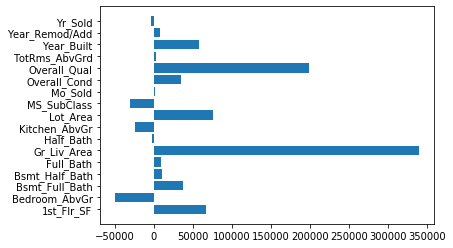

In [17]:
coeff1 = reg_search(train, y_train, test, y_test, feat1)
plt.barh(feat1, coeff1)

Features: 1st_Flr_SF, Bedroom_AbvGr, Bsmt_Full_Bath, Bsmt_Half_Bath, Full_Bath, Gr_Liv_Area, Half_Bath, Kitchen_AbvGr, Lot_Area, MS_SubClass, Mo_Sold, Overall_Cond, Overall_Qual, TotRms_AbvGrd, Year_Built, Year_Remod/Add, Yr_Sold, MS_Zoning

Training score: 0.798960077598204
Training RMSE: 35960.05165851501, MAE: 22150.83689626594, R^2: 0.798960077598204

Testing score: 0.8347059541921693
Testing RMSE: 32091.143458963415, MAE: 21539.982588274866, R^2: 0.8347059541921693


<BarContainer object of 17 artists>

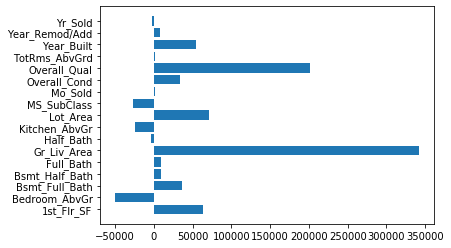

In [18]:
coeff2 = reg_search(train, y_train, test, y_test, feat2)

# cannot plot coefficients for categorical features that's
# one hot encoded. Plotting numerical features only.
plt.barh(feat1, coeff2[:len(feat1)])

Features: 1st_Flr_SF, Bedroom_AbvGr, Bsmt_Full_Bath, Bsmt_Half_Bath, Full_Bath, Gr_Liv_Area, Half_Bath, Kitchen_AbvGr, Lot_Area, MS_SubClass, Mo_Sold, Overall_Cond, Overall_Qual, TotRms_AbvGrd, Year_Built, Year_Remod/Add, Yr_Sold, Bldg_Type, Central_Air, Condition_1, Condition_2, Electrical, Exter_Cond, Exter_Qual, Exterior_1st, Exterior_2nd, Foundation, Functional, Heating, Heating_QC, House_Style, Kitchen_Qual, Land_Contour, Land_Slope, Lot_Config, Lot_Shape, MS_Zoning, Mas_Vnr_Type, Neighborhood, Paved_Drive, Roof_Matl, Roof_Style, Sale_Condition, Sale_Type, Street, Utilities

Training score: 0.9001062565242525
Training RMSE: 25348.268410932094, MAE: 16120.405013020832, R^2: 0.9001062565242525

Testing score: -8.197656480340086e+18
Testing RMSE: 225996360282055.62, MAE: 14446042405327.11, R^2: -8.197656480340086e+18


<BarContainer object of 17 artists>

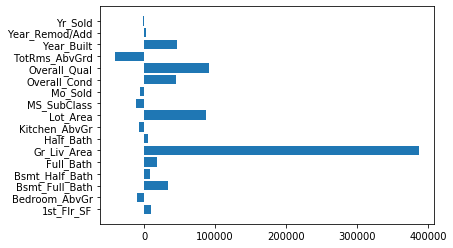

In [19]:
coeff3 = reg_search(train, y_train, test, y_test, feat3)

# cannot plot coefficients for categorical features that's
# one hot encoded. Plotting numerical features only.
plt.barh(feat1, coeff3[:len(feat1)])

## Data Dictionary 

Here's a description of the data fields:

```
1st_Flr_SF: First Floor square feet

Bedroom_AbvGr: Bedrooms above grade (does NOT include basement bedrooms)

Bldg_Type: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
       
Bsmt_Half_Bath: Basement half bathrooms

Bsmt_Full_Bath: Basement full bathrooms

Central_Air: Central air conditioning

       N	No
       Y	Yes
		
Condition_1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition_2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
       
 Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
 Exter_Cond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
 
 Exter_Qual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Exterior_1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior_2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
Full_Bath: Full bathrooms above grade

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Gr_Liv_Area: Above grade (ground) living area square feet
        
Half_Bath: Half baths above grade

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
Heating_QC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

House_Style: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

Kitchen_AbvGr: Kitchens above grade

Kitchen_Qual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Land_Slope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

Lot_Area: Lot size in square feet

Lot_Config: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

Lot_Shape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

MS_SubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MS_Zoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

Mas_Vnr_Type: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

Mo_Sold: Month Sold (MM)

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Overall_Cond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

Overall_Qual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

Paved_Drive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

Roof_Matl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

Roof_Style: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

SalePrice: the sales price for each house

Sale_Condition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

Sale_Type: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
	
Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
TotRms_AbvGrd: Total rooms above grade (does not include bathrooms)

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
Year_Built: Original construction date

Year_Remod/Add: Remodel date (same as construction date if no remodeling or additions)
						
Yr_Sold: Year Sold (YYYY)	

```